# probfit tutorial
Author: Keita Mizukoshi (mzks@stu.kobe-u.ac.jp)

python (numpy+matplotlib) 環境で, Fittingを行うチュートリアル.
現状, 必要なことが簡単にできるのはprobfitとiminuitの組み合わせ.
このチュートリアルでは,python環境で簡単にできるFittingについて紹介し, 可視化までの標準的なやり方について概説する.

### リンク
 - [probfit](https://probfit.readthedocs.io/en/latest/)
 - [iminuit](https://iminuit.readthedocs.io/en/stable/)
 - [probfit online tutorial](https://nbviewer.jupyter.org/github/scikit-hep/probfit/blob/master/tutorial/tutorial.ipynb)


### Install
Consoleで,
```
python -m pip install probfit
```
または, jupyter上でも最初に`!`をつけてセルで実行する.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import probfit
import iminuit

In [2]:
iminuit.__version__ # 現状 2未満のversionが必要.

'1.5.4'

In [3]:
probfit.__version__

'1.2.0'

## Fittingの流れ

 - データを準備する
      - x, y, error (type 1)
      - array (type 2)
      - hisogram (data, edges) (type3)
 - PDF/モデル (i.e., ガウス分布) を設定する
      - pythonでの関数
 - コスト関数を定義する
      - Chi square regression (type 1)
      - Chi square (type 2 and type 3)
      - Binned Likelihood (type 2 and type 3)
      - Unbinned Likelihood (type 2)
 - 最小化ツールを準備
 - Option: 可視化して, 初期値を調整
 - Fitting (コスト関数を最小化)
 - 結果を評価 (値, エラー, 可視化)

## Chi square line fitting

とりあえずline fittingをしながら, Fittingの基礎的な流れを説明する.

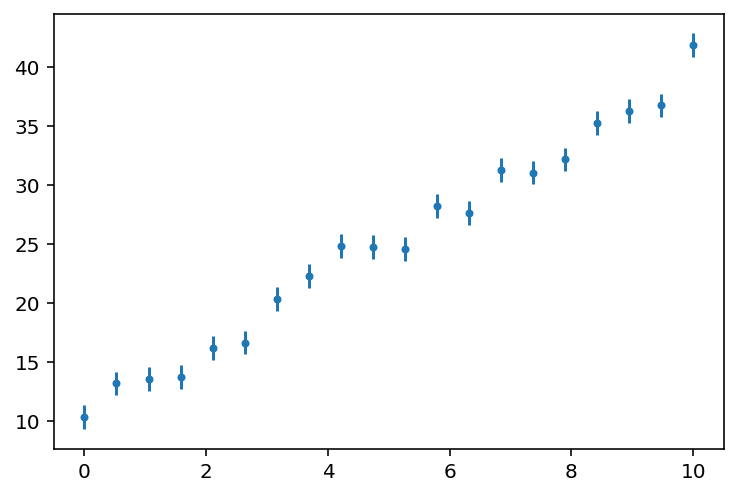

In [4]:
# 説明用のデータをつくる.
# 実際の状況では x, y, errが何かしらの形式で得られているので, 同数のarrayとして用意する.
# errorは省略可能 (全ての点に等しいエラーがつく.)
# Dummy data
x = np.linspace(0, 10, 20)
y = 3 * x + 10 + np.random.randn(len(x))
yerr = np.ones(len(x))
plt.errorbar(x, y, yerr=yerr, fmt='.');

In [5]:
# Fittingして得たいモデル (関数) を準備する.
# ここでは python の意味での関数を定義する.
# 最初の引数はxとして, これはデータ空間のx軸を意味する.
# その後, 引数にパラメーターを列挙する.
# Model
def pol1(x, a, b):
    return a*x+b

In [6]:
# ちゃんとパラメーターが定義できている.
iminuit.describe(pol1)

['x', 'a', 'b']

In [7]:
# コスト関数を定義する.
# コスト関数は一般的にデータとモデルのズレの大きさを表現する.
# Fittingとは, このコスト関数が最小になるパラメータのリストを探す作業である.
# ここでは単純なChi squareを定義する (probfitに用意されている)
# なお, probfitではコスト関数はデータを含む.
# Define a chi^2 cost function
chi2 = probfit.Chi2Regression(pol1, x, y, yerr)

In [8]:
# Minimizerを定義する.
# minuitは前述の最小化を行う際の一般的なツール.
# 作成したコスト関数を引数として渡す.
minuit = iminuit.Minuit(chi2)

/Users/mzks/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: Parameter a does not have neither initial value nor limits.
  after removing the cwd from sys.path.
/Users/mzks/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: Parameter b does not have neither initial value nor limits.
  after removing the cwd from sys.path.


In [9]:
# 最小化を実行する.
minuit.migrad();
# 変数に初期値が設定されていない警告が出るが, 無視できる.
# 適切な初期値を設定することができる. (後述)

In [10]:
minuit.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 25.71                      │         Nfcn = 36 (36 total)         │
│ EDM = 1.07e-21 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [11]:
minuit.values

<ValueView of Minuit at 7fe29fe7f7f0>
  a: 2.913591463556568
  b: 10.460929567103166

In [12]:
minuit.errors

<ErrorView of Minuit at 7fe29fe7f7f0>
  a: 0.0736788398552895
  b: 0.4309458041571342

最小化できた. その際のパラメータの値, エラーをminuitから取得できる.
また, 可視化も簡単に行うことができる.
(若干trickyだが, コスト関数のメソッドとしてあったり, minuitのメソッドとしてあったりする.)

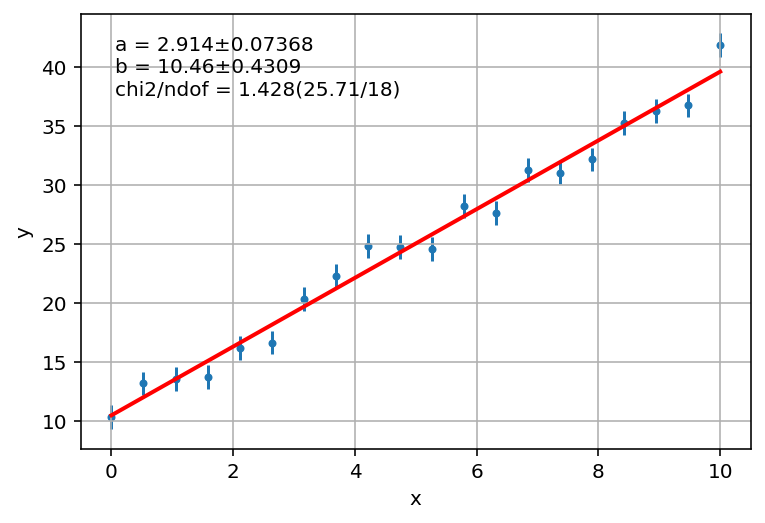

In [13]:
chi2.draw(minuit)
plt.xlabel('x')
plt.ylabel('y');

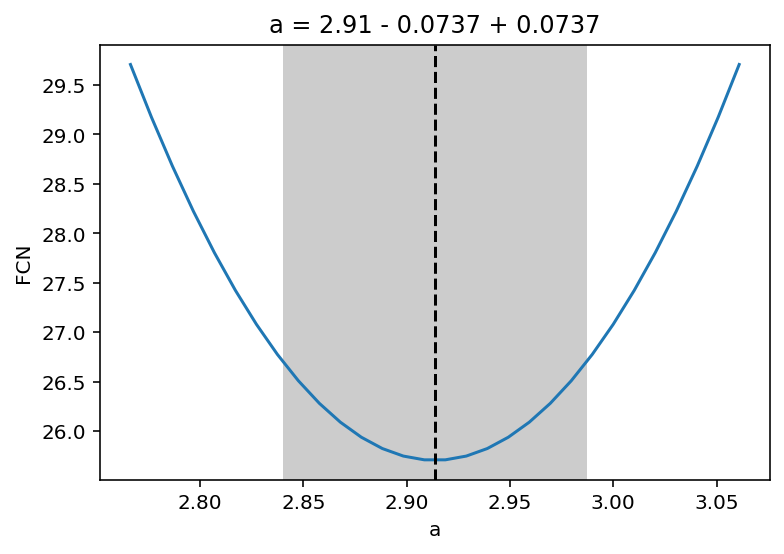

In [14]:
minuit.draw_mnprofile('a');

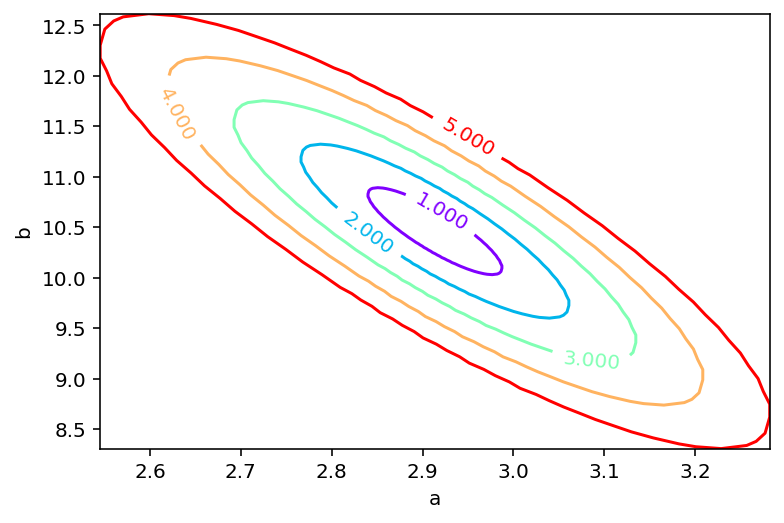

In [15]:
plt.set_cmap('rainbow')
minuit.draw_mncontour('a', 'b', 5)

## Binned Poisson likelihood fit for histogram

GraphのFittingだけでなく, ヒストグラムについてもFittingをおこないたい.
ここではFittingの流れをおさらいしながら, ヒストグラムへのFittingを説明する.

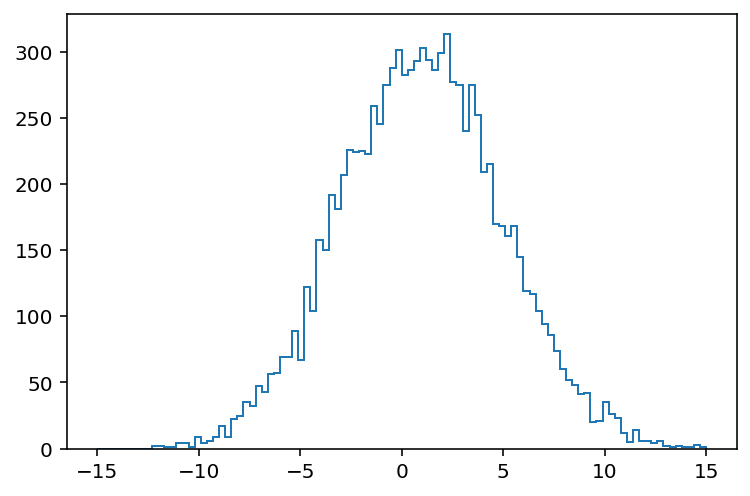

In [16]:
# dummy data
data = np.random.randn(10000) * 4 + 1
plt.hist(data, bins=100, range=(-15, 15), histtype='step');

In [17]:
# Model
def gauss_pdf(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

In [18]:
# Cost function
binned_likelihood = probfit.BinnedLH(gauss_pdf, data)

# データが既にヒストグラムになっている場合も同様に与えて, 
# binned_*のcost function に渡すことができる.
# 特にデータが膨大な際に非常に有効.

#hist = np.histogram(data, bins=100, range=(-15, 15))
#binned_likelihood = probfit.BinnedLH(gauss_pdf, hist)

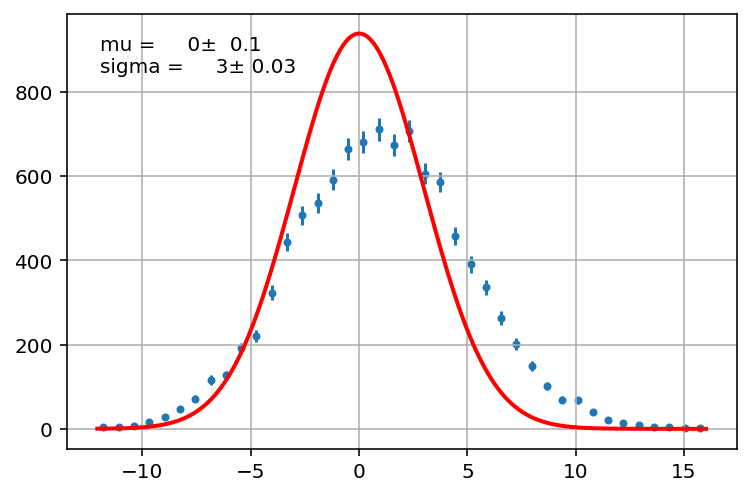

In [19]:
# Minimizer
minuit = iminuit.Minuit(binned_likelihood, mu=0, sigma=3)

# 初期値を与えておけば, 最小化を実行する前に現在のモデルとデータを確認できる.
binned_likelihood.draw(minuit);

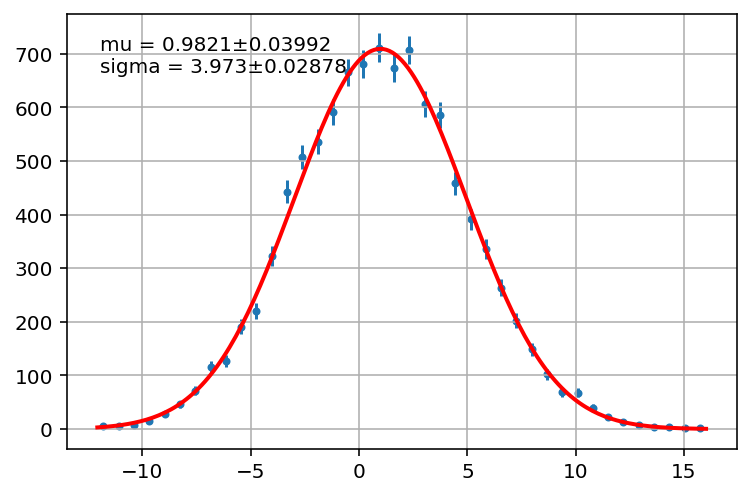

In [20]:
# 最小化 (Fitting)
minuit.migrad()
binned_likelihood.draw(minuit);

In [21]:
minuit.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.03                      │         Nfcn = 46 (46 total)         │
│ EDM = 3.05e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [22]:
minuit.matrix()

,mu,sigma
mu,0.002,-0.000
sigma,-0.000,0.001


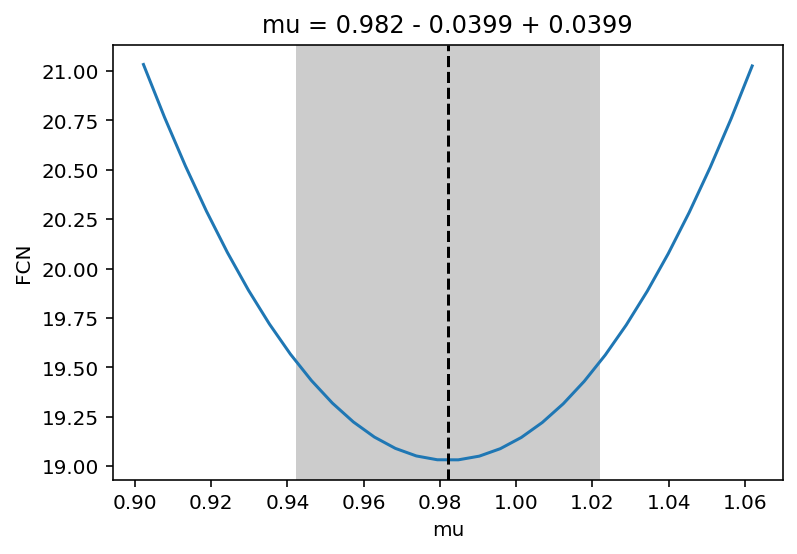

In [23]:
minuit.draw_mnprofile('mu');

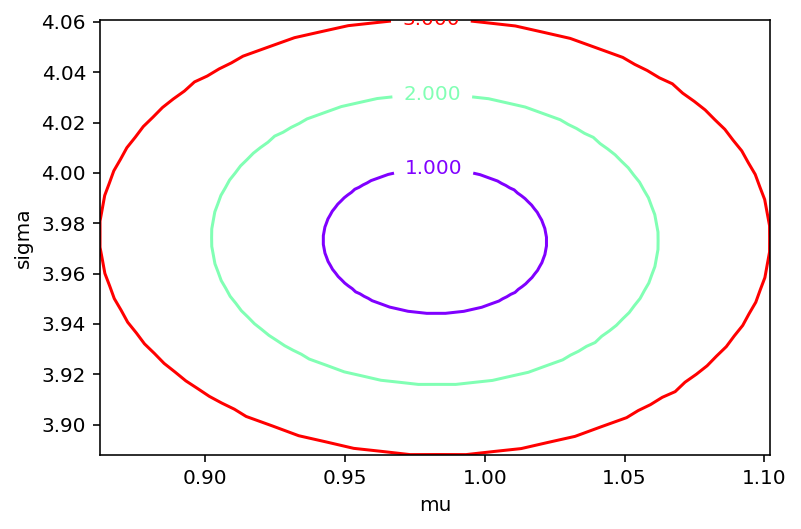

In [24]:
minuit.draw_mncontour('mu', 'sigma', 3)

## Unbinned likelihood fitting とその他のテクニック

もう少し複雑なデータに対してUnbinned likelihood Fittingをおこない, プロットを作成する.

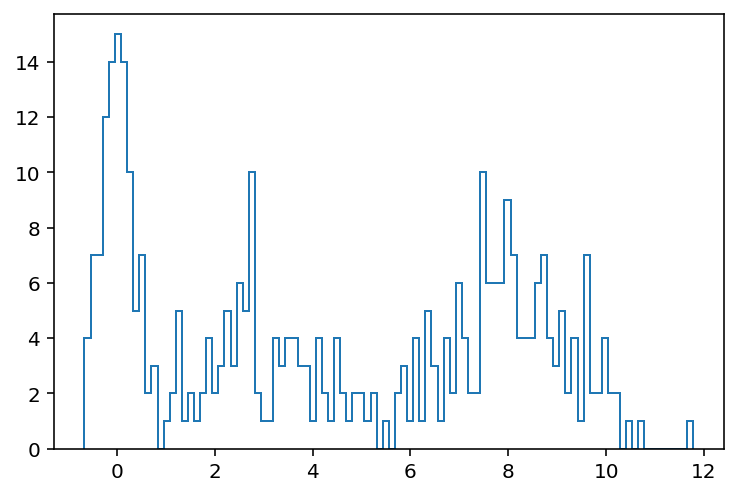

In [25]:
# dummy data
data1 = np.random.randn(100) * 0.4 + 0
data2 = np.random.randn(100) * 1.2 + 3
data3 = np.random.randn(150) * 1.3 + 8
data = np.concatenate([data1, data2, data3])
plt.hist(data, bins=100, histtype='step');

In [26]:
# 高さもパラメーターにした, 3つのガウシアンを定義し, 一つのpdfとして用いる.
gauss1 = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu1', 'sigma1']), extname='N1')
gauss2 = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu2', 'sigma2']), extname='N2')
gauss3 = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu3', 'sigma3']), extname='N3')
pdf = probfit.AddPdf(gauss1, gauss2, gauss3)

In [27]:
# コスト関数として`UnbinnedLH`を指定.
cost = probfit.UnbinnedLH(pdf, data, extended=True)
# pdfが持っているパラメータを表示
probfit.describe(pdf)

['x', 'mu1', 'sigma1', 'N1', 'mu2', 'sigma2', 'N2', 'mu3', 'sigma3', 'N3']

初期値を辞書として渡しておく.
いい初期値を渡しておくと, Fittingがうまくいく.
error_を頭につけると, エラーの大きさも指定できる.

In [28]:
pars = dict(mu1=0, error_mu1=0.1, sigma1=1, N1=100,
            mu2=4, error_mu2=0.1, sigma2=1, N2=40,
            mu3=10,error_mu3=0.1, sigma3=2, N3=100)

In [29]:
minuit = iminuit.Minuit(cost, pedantic=False, print_level=0, **pars)

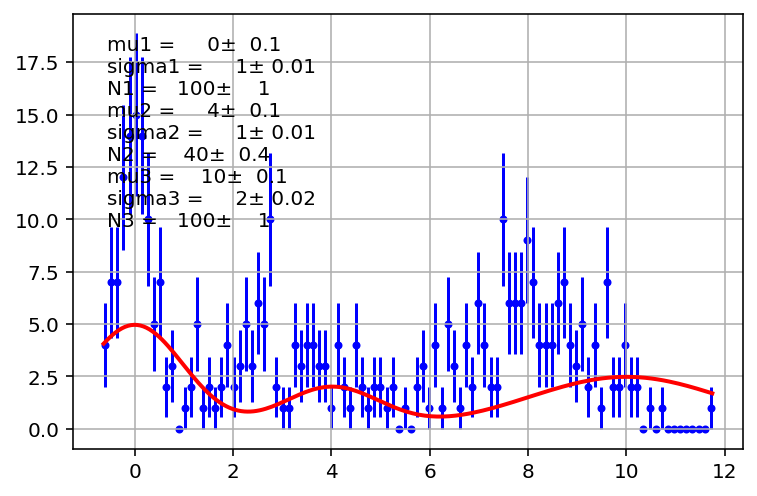

In [30]:
cost.draw(minuit);

はじめからそれなりにデータに合致するように初期値を設定しておくと, フィッティングがうまくいくことがおおい.
ここで可視化して, あまりにずれていれば, 初期値の設定をやり直す.

(かなりずれているように見えるが, これでも最小化でなんとかしてれる. パラメータが多くなってどうしようも無くなれば初期値を頑張ってチューニングする.)

In [31]:
# Fitting
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -910.6                     │        Nfcn = 472 (472 total)        │
│ EDM = 8.94e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu1    │   -0.04   │   0.04    │            │            │         │         │       │
│ 1 │ sigma1 │   0.34    │   0.04    │            │            │         │         │       │
│ 2 │ N1     │    97     │    12     │            │            │         │         │       │
│ 3 │ mu2    │   2.86    │   0.17    │            │            │         │         │       │
│ 4 │ sigma2 │   1.32    │   0.22    │            │            │         │         │       │
│ 5 │ N2     │    106    │    14     │            │            │         │         │       │
│ 6 │ mu3    │   8.05    │   0.13    │            │            │         │         │       │
│ 7 │ sigma3 │   1.26    │   0.10    │            │            │         │         │       │
│ 8 │ N3     │    151    │    13     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

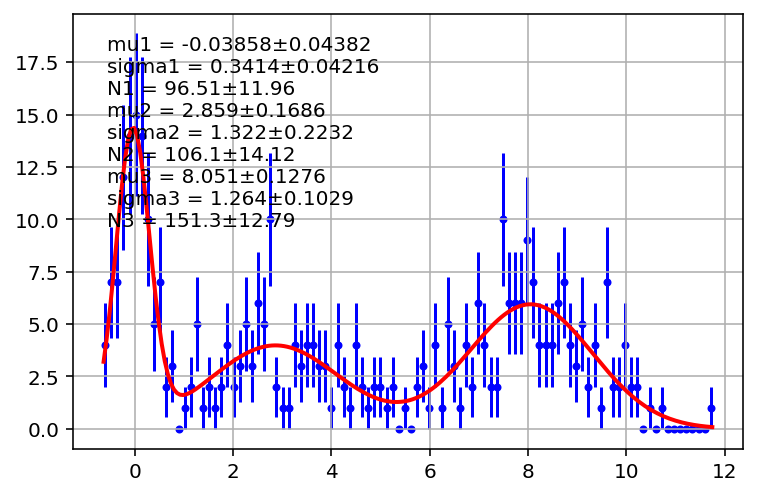

In [32]:
cost.draw(minuit);

どうもちゃんとFittingできていそう.
うまくいっていなければ, 初期値の設定やモデルの設定までもどる.
ただ, この可視化は解析の途中に結果を確認するためには十分だが, plotとして出すときはもう少しお化粧をしたい.

# Visualization

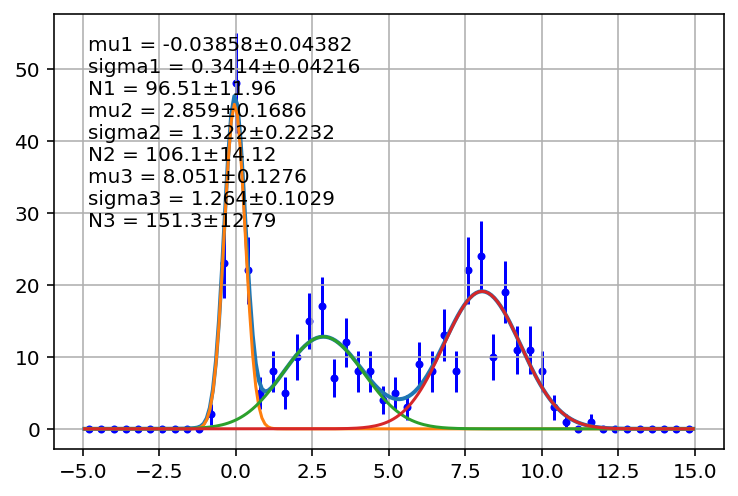

In [33]:
# 可視化に必要なデータを一括で抽出する
# Unbinned fittingをしている時も, ここで可視化のためのBin切りと範囲を指定できる.
((data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y), parts) \
 = cost.draw(minuit, parts=True, bins=50, bound=(-5, 15));

Text(0, 0.5, 'Counts/bin')

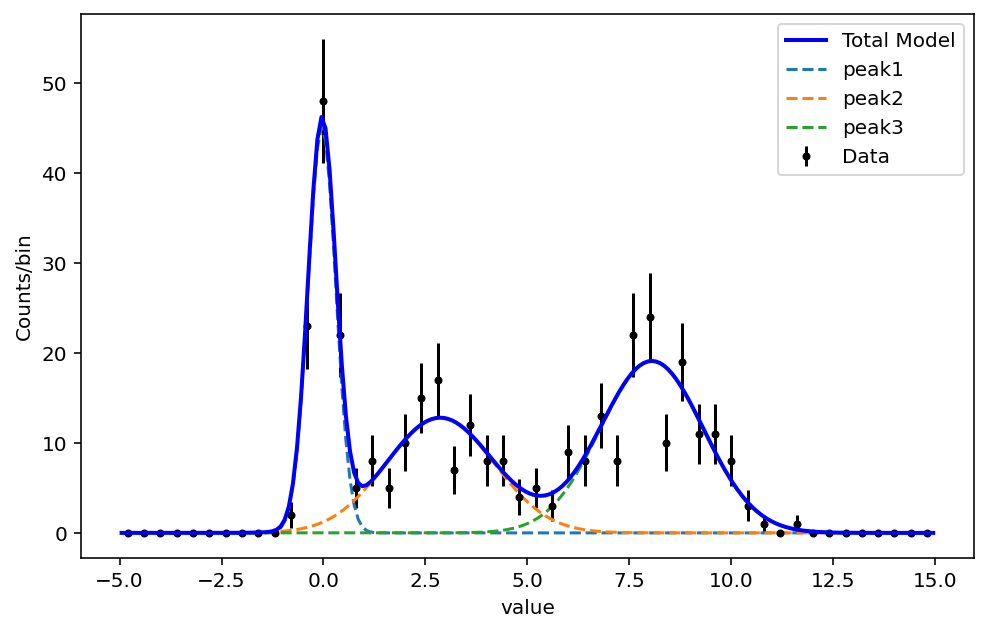

In [34]:
plt.figure(figsize=(8, 5))
plt.errorbar(probfit.mid(data_edges), datay, errorp, fmt='.', capsize=0, color='black', label='Data')
plt.plot(total_pdf_x, total_pdf_y, color='blue', lw=2, label='Total Model', zorder=10)
labels = ['peak1', 'peak2', 'peak3']
for label, part in zip(labels, parts):
    x, y = part
    plt.plot(x, y, ls='--', label=label)
plt.legend(loc='upper right');
plt.xlabel('value')
plt.ylabel('Counts/bin')

まあそれなりに満足できる絵がかけた.

### 追記予定
 - とりあえずない. (公式documentでソース確認すれば大体わかる)
ご要望があれば@mzksまで